In [ ]:
!pip install -q -U tensorflow-hub tensorflow-text tensorflow-addons

In [ ]:
import os
import collections
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

tf.get_logger().setLevel('ERROR')

In [ ]:
root_dir = 'datasets'
annotations_dir = os.path.join(root_dir, 'annotations')
images_dir = os.path.join(root_dir, 'train2014')
tfrecords_dir = os.path.join(root_dir, 'tfrecords')
annotation_file = os.path.join(annotations_dir, 'captions_train2014.json')
if not os.path.exists(annotations_dir):
  annotation_zip = tf.keras.utils.get_file(
      'captions.zip',
      cache_dir = os.path.abspath('.'),
      origin="http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
      extract=True,
  )
  os.remove(annotation_zip)

if not os.path.exists(images_dir):
  image_zip = tf.keras.utils.get_file(
      "train2014.zip",
      cache_dir=os.path.abspath("."),
      origin="http://images.cocodataset.org/zips/train2014.zip",
      extract=True, 
  )
  os.remove(image_zip)

print('Dataset is download and extracted successfully')

with open(annotation_file, 'r') as f:
  annotations = json.load(f)['annotations']

image_path_to_caption = collections.defaultdict(list)
for element in annotations:
  caption = f"{element['caption'].lower().rstrip('.')}"
  image_path = images_dir + "/COCO_train2014_" + "%012d.jpg" % (element['image_id'])
  image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
print(f"Number of images: {len(image_paths)}")

Dataset is download and extracted successfully
Number of images: 82783


In [ ]:
train_size = 30000
valid_size = 5000
captions_per_image = 2
images_per_file = 2000

train_image_paths = image_paths[: train_size]
num_train_files = int(np.ceil(train_size / images_per_file))
train_files_prefix = os.path.join(tfrecords_dir, 'train')

valid_image_paths = image_paths[-valid_size:]
num_valid_files = int(np.ceil(valid_size / images_per_file))
valid_files_prefix = os.path.join(tfrecords_dir, 'valid')

tf.io.gfile.makedirs(tfrecords_dir)

def bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def create_example(image_path, caption):
  feature = {
      'caption': bytes_feature(caption.encode()),
      'raw_image': bytes_feature(tf.io.read_file(image_path).numpy())
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(file_name, image_paths):
  caption_list = []
  image_path_list = []
  for image_path in image_paths:
    captions = image_path_to_caption[image_path][:captions_per_image]
    caption_list.extend(captions)
    image_path_list.extend([image_path] * len(captions))

  with tf.io.TFRecordWriter(file_name) as writer:
    for example_idx in range(len(image_path_list)):
      example = create_example(
          image_path_list[example_idx], caption_list[example_idx]
      )
      writer.write(example.SerializeToString())
  return example_idx + 1

def write_data(image_paths, num_files, files_prefix):
  example_counter = 0
  for file_idx in tqdm(range(num_files)):
    file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
    start_idx = images_per_file * file_idx
    end_idx = start_idx + images_per_file
    example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx])
  return example_counter

train_example_count = write_data(train_image_paths, num_train_files, train_files_prefix)
print(f"{train_example_count} training examples were written to tfrecord files.")

valid_example_count = write_data(valid_image_paths, num_valid_files, valid_files_prefix)
print(f"{valid_example_count} evaluation examples were written to tfrecord files.")

  0%|          | 0/3 [00:00<?, ?it/s]

60000 training examples were written to tfrecord files.


100%|██████████| 3/3 [00:39<00:00, 13.05s/it]

10000 evaluation examples were written to tfrecord files.


In [ ]:
feature_description = {
    'caption': tf.io.FixedLenFeature([], tf.string),
    'raw_image': tf.io.FixedLenFeature([], tf.string)
}

def read_example(example):
  features = tf.io.parse_single_example(example, feature_description)
  raw_image = features.pop('raw_image')
  features['image'] = tf.image.resize(
      tf.image.decode_jpeg(raw_image, channels=3), size=(299, 299)
  )
  return features

def get_dataset(file_pattern, batch_size):
  return (
      tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern)).map(
          read_example,
          num_parallel_calls=tf.data.experimental.AUTOTUNE,
          deterministic=False
      )
      .shuffle(batch_size * 10)
      .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
      .batch(batch_size)
  )

In [ ]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
  projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
  for _ in range(num_projection_layers):
    x = tf.nn.gelu(projected_embeddings)
    x = layers.Dense(projection_dims)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Add()([projected_embeddings, x])
    projected_embeddings = layers.LayerNormalization()(x)
  return projected_embeddings

In [ ]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
  xception = keras.applications.Xception(
      include_top = False,
      weights='imagenet',
      pooling='avg'
  )
  for layer in xception.layers:
    layer.trainable = trainable
  inputs = layers.Input(shape=(299, 299, 3), name='image_input')
  xception_input = tf.keras.applications.xception.preprocess_input(inputs)
  embeddings = xception(xception_input)
  outputs = project_embeddings(
      embeddings, num_projection_layers, projection_dims, dropout_rate
  )
  return keras.Model(inputs, outputs, name='vision_encoder')

In [ ]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
  preprocess = hub.KerasLayer(
      'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2', name='text_preprocessing'
  )
  bert = hub.KerasLayer(
      'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1', 'bert'
  )
  bert.trainable = trainable
  inputs = layers.Input(shape=(), dtype=tf.string, name='text_input')
  bert_inputs = preprocess(inputs)
  embeddings = bert(bert_inputs)['pooled_output']
  outputs = project_embeddings(
      embeddings, num_projection_layers, projection_dims, dropout_rate
  )
  return keras.Model(inputs, outputs, name='text_encoder')

In [ ]:
class DualEncoder(keras.Model):
  def __init__(self, text_encoder, image_encoder, temperature=1.0, **kwargs):
    super(DualEncoder, self).__init__(**kwargs)
    self.text_encoder = text_encoder
    self.image_encoder = image_encoder
    self.temperature = temperature
    self.loss_tracker = keras.metrics.Mean(name='loss')

  @property
  def metrics(self):
    return [self.loss_tracker]

  def call(self, features, training=False):
    with tf.device('/gpu:0'):
      caption_embeddings = text_encoder(features['caption'], training=training)
    with tf.device('/gpu:1'):
      image_embeddings = vision_encoder(features['image'], training=training)
    return caption_embeddings, image_embeddings

  def compute_loss(self, caption_embeddings, image_embeddings):
    logits = (
        tf.matmul(caption_embeddings, image_embeddings, transpose_b = True) / self.temperature
    )
    images_similarity = tf.matmul(
        image_embeddings, image_embeddings, transpose_b = True
    )
    captions_similarity = tf.matmul(
        caption_embeddings, caption_embeddings, transpose_b = True
    )
    targets = keras.activations.softmax(
        (captions_similarity + images_similarity) / (2 * self.temperature)
    )
    captions_loss = keras.losses.categorical_crossentropy(
        y_true = targets,
        y_pred = logits,
        from_logits=True
    )
    images_loss = keras.losses.categorical_crossentropy(
        y_true = tf.transpose(targets),
        y_pred = tf.transpose(logits),
        from_logits=True
    )
    return (captions_loss + images_loss) / 2

  def train_step(self, features):
    with tf.GradientTape() as tape:
      caption_embeddings, image_embeddings = self(features, training=True)
      loss = self.compute_loss(caption_embeddings, image_embeddings)
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    self.loss_tracker.update_state(loss)
    return {'loss': self.loss_tracker.result()}

  def test_step(self, features):
    caption_embeddings, image_embeddings = self(features, training=False)
    loss = self.compute_loss(caption_embeddings, image_embeddings)
    self.loss_tracker.update_state(loss)
    return {'loss': self.loss_tracker.result()}

In [ ]:
num_epochs = 5
batch_size = 256

vision_encoder = create_vision_encoder(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1
)
text_encoder = create_text_encoder(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate = 0.1
)
dual_encoder = DualEncoder(text_encoder, vision_encoder, temperature=0.05)
dual_encoder.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001)
)

In [ ]:
print(f"Number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Number of examples (caption-image pairs): {train_example_count}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {int(np.ceil(train_example_count / batch_size))}")
train_dataset = get_dataset(os.path.join(tfrecords_dir, 'train-*.tfrecord'), batch_size)
valid_dataset = get_dataset(os.path.join(tfrecords_dir, 'valid-*.tfrecord'), batch_size)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
history = dual_encoder.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=[reduce_lr, early_stopping]
)
print('Training completed. Saving vision and text encoders...')
vision_encoder.save('vision_encoder')
text_encoder.save('text_encoder')
print('Models ar saved.')

Number of GPUs: 1
Number of examples (caption-image pairs): 60000
Batch size: 256
Steps per epoch: 235
Epoch 1/5
235/235 [==============================] - 1321s 5s/step - loss: 64.5259 - val_loss: 9.6705
Epoch 2/5
235/235 [==============================] - 1274s 5s/step - loss: 8.1765 - val_loss: 5.1975
Epoch 3/5
235/235 [==============================] - 1271s 5s/step - loss: 4.6813 - val_loss: 4.8003
Epoch 4/5
235/235 [==============================] - 1274s 5s/step - loss: 3.9209 - val_loss: 4.5409
Epoch 5/5
235/235 [==============================] - 1276s 5s/step - loss: 3.4715 - val_loss: 4.2076
Training completed. Saving vision and text encoders...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Models ar saved.


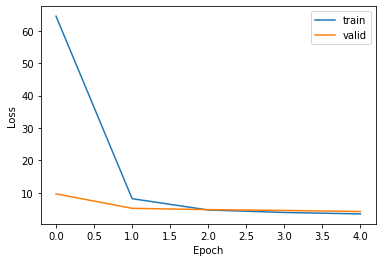

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
print('Loading vision and text encoders...')
vision_encoder = keras.models.load_model('vision_encoder')
text_encoder = keras.models.load_model('text_encoder')
print('Models are loaded.')

def read_image(image_path):
  image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
  return tf.image.resize(image_array, (299, 299))

print(f"Generating embeddings for {len(image_paths)} images...")
image_embeddings = vision_encoder.predict(
    tf.data.Dataset.from_tensor_slices(image_paths).map(read_image).batch(batch_size),
    verbose=1
)
print(f"Image embeddings shape: {image_embeddings.shape}")

Loading vision and text encoders...
Models are loaded.
Generating embeddings for 82783 images...
324/324 [==============================] - 705s 2s/step
Image embeddings shape: (82783, 256)


In [ ]:
def find_matches(image_embeddings, queries, k=9, normalize=True):
  query_embedding = text_encoder(tf.convert_to_tensor(queries))

  if normalize:
    image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
    query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
  
  dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b = True)
  results = tf.math.top_k(dot_similarity, k).indices.numpy()
  return [[image_paths[idx] for idx in indices] for indices in results]

In [ ]:
query = 'a family standing next to the ocean on a sandy beach with a surf board'
matches = find_matches(image_embeddings, [query], normalize=True)[0]

plt.figure(figsize=(20, 20))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(mping.imread(matches[i]))
  plt.axis('off')

In [ ]:
def compute_top_k_accuracy(image_paths, k=100):
  hits = 0
  num_batches = int(np.ceil(len(image_paths) / batch_size))
  for idx in tqdm(range(num_batches)):
    start_idx = idx * batch_size
    end_idx = start_idx + batch_size
    current_image_paths = image_paths[start_idx: end_idx]
    queries = [
        image_path_to_caption[image_path][0] for image_path in current_image_paths
    ]
    result = find_matches(image_embeddings, queries, k)
    hits += sum(
        [
         image_path in matches
         for (image_path, matches) in list(zip(current_image_paths, result))
        ]
    )
  reulst hits / len(image_paths)

print('Scoring training data ...')
train_accuracy = compute_top_k_accuracy(train_image_paths)
print(f"Train accuracy: {round(train_accuracy * 100, 3)}%")

print("Scoring evaluation data...")
eval_accuracy = compute_top_k_accuracy(image_paths[train_size: ])
print(f"Eval accuracy: {round(eval_accuracy * 100, 3)}%")